## Quick check any physics parameters for a single file

In [12]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib, shlex, subprocess
import xbout
import scipy
import xhermes
from xhermes import *


sys.path.append(r"/users/jpm590/2dspace/post-processing/sdtools/")


from hermes3.utils import *


from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.selectors import *

%load_ext autoreload
%autoreload 2
print("Done")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done


In [14]:
db = CaseDB(
    case_dir = r"/users/jpm590/scratch/",
    # grid_dir = r"/users/jpm590/2dspace/hermes-3/build-mc-master"
    grid_dir = r"/users/jpm590/neutralrun/hermes-3/master"

)

toload = [
    dict(name="MAST-U", id="251205-cdn-46895", unnormalise_geom = True, use_xhermes = True, squash = True)
    # dict(name="MAST-U", id="251007-2D-MASTU", unnormalise_geom = True, use_xhermes = True, squash = True)

]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)
    cs[case["name"]].extract_2d_tokamak_geometry()

- Reading case 251205-cdn-46895
-----------------------
- Looking for squash file
- Squash file found. squash date 12/05/2025, 23:41:11, dmp file date 12/05/2025, 23:34:17


/users/jpm590/workspace/hermes-3/venv/lib/python3.12/site-packages/xbout/load.py:1124: UserWarning: Will drop all variables containing the dimensions 'closed_wall' because they are not recognised
  warn(



Unnormalising with xHermes


### Calculate the total power source
By `Pd+_src` + `Pe_src` times dv

Energy = 3/2 * pressure * volume 

`P_src` are in per second. So it's Power = 3/2 * P_src * dv

In [16]:
ds = cs["MAST-U"].ds.isel(t=-1)
power = 3/2 * (ds["Pd+_src"].values + ds["Pe_src"].values + ds["Pd_src"].values) * ds["dv"].values
power = np.sum(power)
print(f"Total power source = {power}")

print(ds["Pd_src"].values)
arr = ds["Pd_src"].values

# indices of non-zero elements
idx = np.nonzero(arr)
# or equivalently
idx = np.where(arr != 0)

print(f"At {idx}, the value is {ds["Pd_src"].values[idx]}")
# print(ds["dv"])

Total power source = 1004973.1363427014
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
At (array([], dtype=int64), array([], dtype=int64)), the value is []


In [5]:
ds = cs["MAST-U"].ds.isel(t=-1)

nparticles = (ds["Sd_src"].values) * ds["dv"].values
print(nparticles)
nparticles = np.sum(nparticles)
print(f"Total number of particles = {nparticles}")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Total number of particles = 5e+21


## Calculate volume

Get the volume of the region you want.

You could possibly choose ([reference](https://github.com/mikekryjak/sdtools/blob/4242b6f0a55edf66d0b6e6f706bb7dc8515eb143/hermes3/deprecated/stuff.py#L155)): 
```python 
    core = ds.hermesm.select_region("core_edge")
    sol = ds.hermesm.select_region("sol_edge")
    pfr = ds.hermesm.select_region("pfr_edge")
    domain = ds.hermesm.select_region("all_noguards")
    domain_volume = domain["dv"].values.sum()
```
When you change a grid, the core volume is changed as well, therefore check "core_edge"

In [17]:
ds = cs["MAST-U"].ds.isel(t=-1)
domain = ds.hermesm.select_region("core_edge")
domain_volume = domain["dv"].values.sum()
print(domain_volume)
# dv = (ds["dv"]).values
# display(dv)
# V = np.sum(dv)
# print(V)


0.2968858850770253


### Find the first core ring
The fuel is fuelling in the first core ring, so you should find the correct normalised position for fuelling function in input file.

```python
source = H(x) * H({first core ring} - x) * pressure_source
```

Below `sep` shows the position of the separatrix. `Srad` is the real distance from the separatrix (-: core, +: Sol). Note that `Srad` is in the cell center, while the real separatrix is on the boundary.


,t,total_poloidal_distance,zeta,dr,dx,Pe_src,Srad,sep
0,0.00002,3.831418,3.141593,0.007483,0.002440,1.127586e+06,-0.058898,0
1,0.00002,3.943389,3.141593,0.006791,0.002215,0.000000e+00,-0.051761,0
2,0.00002,4.049806,3.141593,0.006145,0.002003,0.000000e+00,-0.045293,0
3,0.00002,4.150752,3.141593,0.005542,0.001805,0.000000e+00,-0.039449,0
4,0.00002,4.246313,3.141593,0.004980,0.001619,0.000000e+00,-0.034188,0
5,0.00002,4.336584,3.141593,0.004459,0.001447,0.000000e+00,-0.029469,0
6,0.00002,4.421685,3.141593,0.003977,0.001288,0.000000e+00,-0.025251,0
7,0.00002,4.501782,3.141593,0.003534,0.001143,0.000000e+00,-0.021496,0
8,0.00002,4.577099,3.141593,0.003131,0.001010,0.000000e+00,-0.018164,0
9,0.00002,4.647935,3.141593,0.002767,0.000891,0.000000e+00,-0.015215,0


<Axes: >

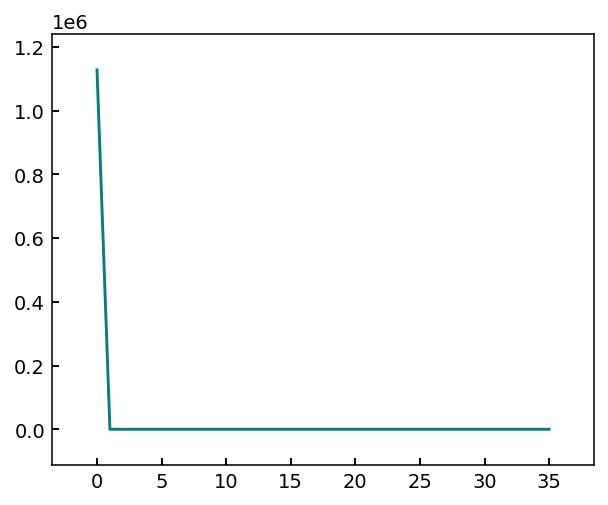

In [25]:
ds = cs["MAST-U"].ds.isel(t=-1)
df = get_1d_radial_data(ds, params = ["dx", "Pe_src"], region = "omp")
display(df)

fig, ax = plt.subplots()
df["Pe_src"].plot()




To get the normalised core ring position `x`, take `x` by cumulatively summing up the dx (width of each cell). Then normalised it by dividing max value.

The value you should take is the `x` where `Pe_src` is non-zero (1st core ring)

In [27]:
df["x"] = df["dx"].cumsum()
# x is in the center of the cell
df["x"] = df["x"]/df["x"].max()
df
# use the first 0.08

,t,total_poloidal_distance,zeta,dr,dx,Pe_src,Srad,sep,x
0,0.00002,3.831418,3.141593,0.007483,0.002440,1.127586e+06,-0.058898,0,0.071421
1,0.00002,3.943389,3.141593,0.006791,0.002215,0.000000e+00,-0.051761,0,0.136254
2,0.00002,4.049806,3.141593,0.006145,0.002003,0.000000e+00,-0.045293,0,0.194888
3,0.00002,4.150752,3.141593,0.005542,0.001805,0.000000e+00,-0.039449,0,0.247709
4,0.00002,4.246313,3.141593,0.004980,0.001619,0.000000e+00,-0.034188,0,0.295104
5,0.00002,4.336584,3.141593,0.004459,0.001447,0.000000e+00,-0.029469,0,0.337462
6,0.00002,4.421685,3.141593,0.003977,0.001288,0.000000e+00,-0.025251,0,0.375170
7,0.00002,4.501782,3.141593,0.003534,0.001143,0.000000e+00,-0.021496,0,0.408616
8,0.00002,4.577099,3.141593,0.003131,0.001010,0.000000e+00,-0.018164,0,0.438186
9,0.00002,4.647935,3.141593,0.002767,0.000891,0.000000e+00,-0.015215,0,0.464269
